<h1><center>Forward Regression Orthogonal Estimator</center></h1>

<h3>This is the implementation of the FROE algorithm and its application for a non-linear identification (heat exchanger process) </h3>

<p>Import of the libraries</p>

In [1]:
# library to create the Polynomial Expansion of different degree
from sklearn.preprocessing import PolynomialFeatures

# library to use the numpy array
import numpy as np

# library to plot 
import matplotlib.pyplot as plt

# library to calculate the mean square error
from sklearn.metrics import mean_squared_error

# library to check the progress of a loop
from tqdm import tqdm

# set dimensions of the plot
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


<p>Read data from files
<ul>
<li>$y(t)$ is the outlet liquid temperature</li>
<li>$u(t)$ is the liquid flow rate</li>
</ul>
The model used is: <br>
<center>$\hat{y} (t+1|t) = f(y(t), y(t-1) ... y(t-3); u(t), u(t-1), ... u(t-9))$</center>
</p>

In [2]:
# open file and read data
data = open('../exchanger/exchanger.dat')
lst = []
for line in data:
    lst += [line.split()]
time = [float(x[0]) for x in lst]

# inputs
u = [float(x[1]) for x in lst]

# outputs
y = [float(x[2]) for x in lst]

# means of the inputs and outputs
avg_y = np.mean(y)
avg_u = np.mean(u)

<p>Divide the dataset in identification and validation set</p>

In [3]:
# identification length
ID_LENGHT = 3000

# validetion length
VAL_LENGHT = 1000

# identification set and means
time_id = time[:ID_LENGHT]
u_id = u[:ID_LENGHT]
y_id = y[:ID_LENGHT]
avg_y_id = np.mean(y_id)
avg_u_id = np.mean(u_id)

# validation set and means
time_val = time[ID_LENGHT:]
u_val = u[ID_LENGHT:]
y_val = y[ID_LENGHT:]
avg_y_val = np.mean(y_val)
avg_u_val = np.mean(u_val)

<p>Definition of the:
<ul>
<li>Autoregressive part: AR_deg;</li>
<li>Exogenus part: X_deg;</li>
<li>Degree of the polynomial expansion: poly_degree.</li>
</ul>
</p>

In [55]:
AR_deg = 2
X_deg = 2
poly_degree = 2


The model used is: <br>
<center>$\hat{y} (t+1|t) = f(y(t), y(t-1) ... y(t-3); u(t), u(t-1), ... u(t-9))$</center>


<p>Creation of the features of the polynomial expansion</p>

In [56]:
features = []
for i in reversed(range(X_deg)):
    if i==0:
        features.append("u(t)")
    else:
        features.append("u(t-{})".format(i))
for i in reversed(range(AR_deg)):
    if i==0:
        features.append("y(t)")
    else:
        features.append("y(t-{})".format(i))
        
print("Model: y(t+1|t) = f({}, ... , {}, {}, ... ,{})".format(features[-1],features[-AR_deg], \
                                                              features[X_deg-1],features[0]))
print("Where f() is a polynomial expansion of the {} degree".format(poly_degree))

Model: y(t+1|t) = f(y(t), ... , y(t-1), u(t), ... ,u(t-1))
Where f() is a polynomial expansion of the 2 degree


<h5>Froe Method: </h5>
<p>
 $Y = \Phi\vartheta + E = Wg + E$ <br>
 $W = \Phi -W(A-I)$ <br>
 $A = (W^TW)^{-1}W^T\Phi$ <br>
 $\hat{g} = (W^TW)^{-1}W^TY $ <br>
 $\vartheta = g - (A-I) \vartheta $ 
</p> 

<p>Creation of the matrix of the regressors: $\Phi$</p>

In [57]:
poly = PolynomialFeatures(poly_degree)
Y = np.array(y_id)
reg_u = np.full(X_deg,avg_u_id)
reg_y = np.full(AR_deg,avg_y_id)
PHI = []
for i in range(ID_LENGHT):
    if i!=0:
        reg_y = np.append(reg_y, Y[i])[1:]
        reg_u = np.append(reg_u, u_id[i])[1:]
    regressors = np.append(reg_u, reg_y)
    PHI.append(poly.fit_transform([regressors])[0])
PHI = np.array(PHI)
regressor_terms = poly.get_feature_names(features)
print("N° of regressors: ", len(regressor_terms))

N° of regressors:  15


<p>Initialize useful matrices and threshold of the err</p>

In [58]:
A = np.zeros((PHI.shape[1],PHI.shape[1]))
W = np.zeros(PHI.shape)
g_hat = np.array([])
np.fill_diagonal(A,1)
regressor_selected = np.array([], dtype=int)
err_sum = 0
threshold = 0.05

<h5>Froe implementation:</h5>
<p>
<ol>
<li>
<ol>
<li>
Test all $\varphi_i (t), i = 1, ...,n,$ for inclusion in the model as $w_1(t)$.
</li>
<li>
Precisely, set $w_1^{(i)}(t) = \varphi_i(t)$;
</li>
<li>
Calculate $\hat{g}_1^{(i)} = \frac{\sum_{t=1}^{N} w_1^{(i)}(t)y(t)}{\sum_{t=1}^{N} w_1^{(i)}(t)^2}$;
</li>
<li>
$[err]_1^{(i)} = (\hat{g}_1^{(i)})^2 \frac{\sum_{t=1}^{N} w_1^{(i)}(t)^2}{\sum_{t=1}^{N} y(t)^2}$;
</li>
<li>
Let $j = arg max_i ([err]_1^{(i)})$.
</li>
<li>
Then, select $w_1(t) = w_1^{(j)} = \varphi_j(t)$</li>
<li>$\hat{g}_1 = \hat{g}_1^{(j)}$ </li><li> $[err]_1 = [err]_1^{(j)}$</li>
</ol><br>
</li>
<li>
<ol>
<li>Now, test all $\varphi_i (t), i = 1, ...,n, i \neq j$ for inclusion in the model as $w_2(t)$
</li>
<li>
Set $w_2^{(i)}(t) = \varphi_i(t) - a_{12}^{(i)}w_1(t)$
</li>
<li>
where $a_{12}^{(i)} =  \frac{\sum_{t=1}^{N} w_1(t)\varphi_i(t)}{\sum_{t=1}^{N} w_1(t)^2}$
</li>
<li>
Calculate $\hat{g}_2^{(i)} = \frac{\sum_{t=1}^{N} w_2^{(i)}(t)y(t)}{\sum_{t=1}^{N} w_2^{(i)}(t)^2}$;
</li>
<li>
$[err]_2^{(i)} = (\hat{g}_2^{(i)})^2 \frac{\sum_{t=1}^{N} w_2^{(i)}(t)^2}{\sum_{t=1}^{N} y(t)^2}$;
</li>
<li>
Let $j = arg max_i ([err]_2^{(i)})$.
</li>
<li>
Then, select $w_2(t) = w_2^{(j)}(t)$</li>
<li>$\hat{g}_2 = \hat{g}_2^{(j)}$ </li><li> $[err]_2 = [err]_2^{(j)}$</li>
</ol><br>
</li>
<li>
Iterate the procedure until a sufficient portion of the output variance has been
explained, i.e. until $1 − \sum_{i=1}^{ns} [err]_i$ is less than a prescribed tolerance.
</li>
<li>
<ol>
<li>
$\hat{\vartheta}_n = \hat{g}_n$; 
</li>
<li>
$\hat{\vartheta}_i = \hat{g}_i - \sum_{k=i+1}^{n} a_{ik}\hat{\vartheta}_k, i = n-1, ..., 1$
</li>
</ol>
</li>
</ol>
</p>

In [59]:
previous_MSE = 0
for k in range(PHI.shape[1]):
    srr = np.array([])
    MSSEs = np.array([])
    g = np.array([])
    if k == 0:
        
        # 1.A
        for i in range(PHI.shape[1]):
            
            # 1.B
            W[:,0] = PHI[:,i]
            
            # 1.C
            g_i = np.dot(W[:,0],Y)/np.power(np.linalg.norm(W[:,0]),2)
            g = np.append(g, g_i)
            
            # SIMULATE - srr
            g_hat_temp = np.append(g_hat, g_i)
            theta_temp = np.zeros(len(g_hat_temp))
            for m in reversed(range(len(g_hat_temp))):
                # 4.A
                if m == len(g_hat_temp):
                    theta_temp[m] = g_hat_temp[m]
                
                # 4.B
                else:
                    temp = 0
                    for q in range(m+1, len(g_hat_temp)):
                        temp += A[m,q] * theta_temp[q]
                    theta_temp[m] = g_hat_temp[m] - temp
            #Simulate
            poly = PolynomialFeatures(poly_degree)
            regressor_selected_temp = np.append(regressor_selected, i)
            print("Considered regressors:")
            for el in regressor_selected_temp:
                print(el)
            reg_y = np.full(AR_deg,0)
            reg_u = u_val[:X_deg]
            reg = np.append(reg_u,reg_y)
            reg = poly.fit_transform([reg])[0]
            model_reg = reg[regressor_selected_temp]
            y_hat_sim  = []
            try:
                for q in range(ID_LENGHT - X_deg):
                    y_i = np.dot(model_reg,theta_temp) #simulated
                    y_hat_sim.append(y_i)
                    reg_y = np.append(reg_y, y_hat_sim[q])[1:]
                    reg_u = np.append(reg_u, u_id[X_deg+q])[1:]  #append at the end, then remove the first one([:1])
                    reg = np.append(reg_u,reg_y)
                    reg = poly.fit_transform([reg])[0]
                    model_reg = reg[regressor_selected_temp]
                MSE_sim = mean_squared_error(Y[X_deg:],y_hat_sim)
                MSSEs = np.append(MSSEs, MSE_sim)
                srr_i = MSE_sim / np.power(np.linalg.norm(Y[X_deg:]),2)
                print("Regressor n° {}, testing regressor {}, srr = {}, MSSE = {} , previous = {}".format(k+1, regressor_terms[i],\
                                                                                                  srr_i, MSE_sim, previous_MSE))
                srr = np.append(srr, srr_i)
            except ValueError:
                print("VALUE ERROR!")
                MSSEs = np.append(MSSEs, 100000)
                srr = np.append(srr, -100)
                
        
        # 1.E
        j = np.argmin(srr)
        previous_MSE = MSSEs[j]
        print(previous_MSE, len(srr), len(MSSEs))
        print("Srr min: {}, associated with regressors {}".format(srr[j], regressor_terms[j]))
        
        # 3
        if (srr[j] < 0):
            print('Srr became negative: {}'.format(srr[j]))
            break;
        # 1.F
        W[:,0] = PHI[:,j]
        
        # 1.G
        g_hat = np.append(g_hat, g[j])
        regressor_selected = np.append(regressor_selected, j)
        print("Regressor selected ", regressor_selected, k)
        
    else:
        
        # 2.A
        for l in range(PHI.shape[1]):
            if l not in regressor_selected:
                temp = np.zeros(PHI.shape[0])
                
                # 2.C
                for i in range(k):
                    A[i,k] = (np.dot(W[:,i],PHI[:,l]))/np.power(np.linalg.norm(W[:,i]),2)
                    temp += A[i,k] * W[:,i]
                    
                # 2.B
                W[:,k] = PHI[:,l] - temp
                
                # 2.D
                g_i = np.dot(W[:,k],Y)/np.power(np.linalg.norm(W[:,k]),2)
                g = np.append(g, g_i)
                
                # 2.E
                # SIMULATE - srr
                g_hat_temp = np.append(g_hat, g_i)
                theta_temp = np.zeros(len(g_hat_temp))
                for m in reversed(range(len(g_hat_temp))):
                    if m == len(g_hat_temp):
                        theta_temp[m] = g_hat_temp[m]
                    else:
                        temp = 0
                        for q in range(m+1, len(g_hat_temp)):
                            temp += A[m,q] * theta_temp[q]
                        theta_temp[m] = g_hat_temp[m] - temp
                #Simulate
                poly = PolynomialFeatures(poly_degree)
                regressor_selected_temp = np.append(regressor_selected, l)
                print("Considered regressors:")
                for el in regressor_selected_temp:
                    print(el)
                reg_y = np.full(AR_deg,0)
                reg_u = u_val[:X_deg]
                reg = np.append(reg_u,reg_y)
                reg = poly.fit_transform([reg])[0]
                model_reg = reg[regressor_selected_temp]

                y_hat_sim  = []
                try:
                    for i in range(ID_LENGHT - X_deg):
                        y_i = np.dot(model_reg,theta_temp) #simulated
                        y_hat_sim.append(y_i)
                        reg_y = np.append(reg_y, y_hat_sim[i])[1:]
                        reg_u = np.append(reg_u, u_id[X_deg+i])[1:]  #append at the end, then remove the first one([:1])
                        reg = np.append(reg_u,reg_y)
                        reg = poly.fit_transform([reg])[0]
                        model_reg = reg[regressor_selected_temp]
                    MSE_sim = mean_squared_error(Y[X_deg:],y_hat_sim)
                    MSSEs = np.append(MSSEs, MSE_sim)
                    srr_i = (previous_MSE - MSE_sim) / np.power(np.linalg.norm(Y[X_deg:]),2)
                    print("Regressor n° {}, testing regressor {}, srr = {}, MSSE = {}, previous = {}".format(k+1, regressor_terms[l], \
                                                                                                    srr_i, MSE_sim, previous_MSE))
                    srr = np.append(srr, srr_i)
                except ValueError:
                    print("VALUE ERROR!")
                    MSSEs = np.append(MSSEs, 100000)
                    srr = np.append(srr, -100)
            else:
                srr = np.append(srr, -100)
                g = np.append(g, 0)
                MSSEs = np.append(MSSEs, 100000)
                
        # 2.F
        j = np.argmax(srr)
        previous_MSE = MSSEs[j]
        print(previous_MSE, len(srr), len(MSSEs))
        print("Srr max: {}, associated with regressors {}".format(srr[j], regressor_terms[j]))
        
        # 3
        if (srr[j] < 0):
            print('Srr became negative: {}'.format(srr[j]))
            break;
        # 2.G
        for i in range(k):
            A[i,k] = (np.dot(W[:,i],PHI[:,j]))/np.power(np.linalg.norm(W[:,i]),2)
            temp += A[i,k] * W[:,i]
        W[:,k] = PHI[:,j] - temp
        
        # 2.H
        g_hat = np.append(g_hat, g[j])
        regressor_selected = np.append(regressor_selected, j)
        
        

theta = np.zeros(len(g_hat))
for i in reversed(range(len(g_hat))):
    
    # 4.A
    if i == len(g_hat):
        theta[i] = g_hat[i]
        
    # 4.B
    else:
        temp = 0
        for k in range(i+1, len(g_hat)):
            temp += A[i,k] * theta[k]
        theta[i] = g_hat[i] - temp

Considered regressors:
0
Regressor n° 1, testing regressor 1, srr = 1.0908029964338223e-07, MSSE = 3.090340521629761 , previous = 0
Considered regressors:
1
Regressor n° 1, testing regressor u(t-1), srr = 5.5857948383647735e-05, MSSE = 1582.504649413684 , previous = 0
Considered regressors:
2
Regressor n° 1, testing regressor u(t), srr = 5.583546541098907e-05, MSSE = 1581.8676870870227 , previous = 0
Considered regressors:
3
Regressor n° 1, testing regressor y(t-1), srr = 0.0003335557038025351, MSSE = 9449.925523231232 , previous = 0
Considered regressors:
4
Regressor n° 1, testing regressor y(t), srr = 0.0003335557038025351, MSSE = 9449.925523231232 , previous = 0
Considered regressors:
5
Regressor n° 1, testing regressor u(t-1)^2, srr = 0.00013661978436699804, MSSE = 3870.558268229589 , previous = 0
Considered regressors:
6
Regressor n° 1, testing regressor u(t-1) u(t), srr = 0.0001167468188670769, MSSE = 3307.539732617394 , previous = 0
Considered regressors:
7
Regressor n° 1, testi

<p>Refactor $\Phi$ considering only the regressor selected by the identification process</p>

In [17]:
PHI_final = np.zeros((PHI.shape[0], len(regressor_selected)))
for i in range(len(regressor_selected)):
    PHI_final[:,i] = PHI[:, regressor_selected[i]]

<h5>Prediction: $\hat{y} = \Phi \vartheta$ </h5>

In [18]:
y_hat = np.dot(PHI_final, theta)

<p>Plot of the process and the prediction on the identification set</p>

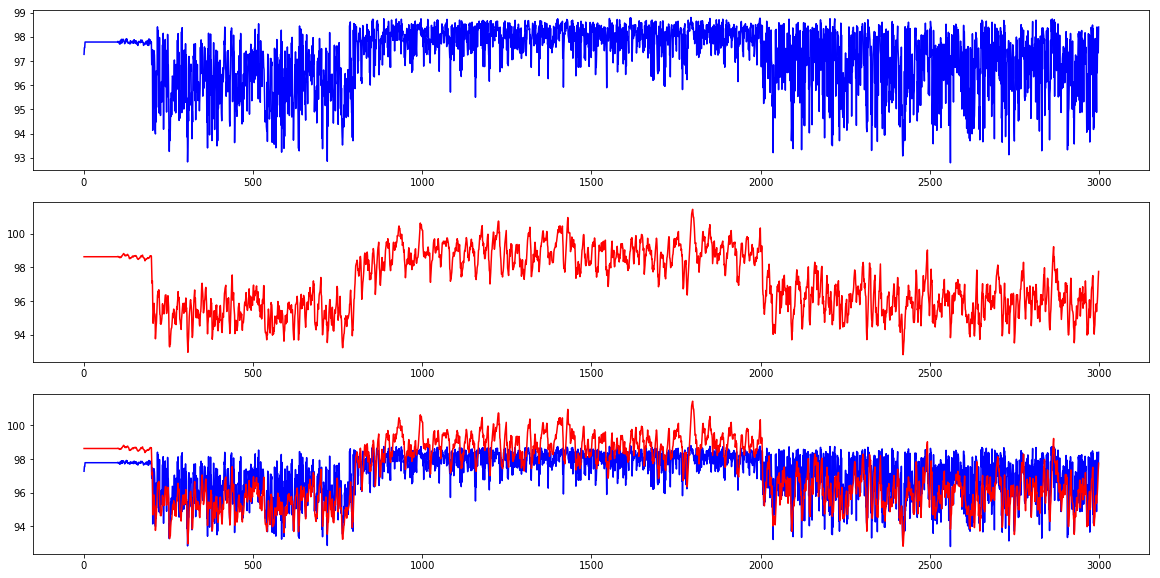

MSE on identification:  1.53415392167


In [20]:
plt.subplot(311)
plt.plot(y_hat, color='blue')
plt.subplot(312)
plt.plot(y_id, color='red')
plt.subplot(313)
plt.plot(y_hat, color='blue')
plt.plot(y_id, color='red')
plt.show()

MSE_id = mean_squared_error(y_id,y_hat)
print("MSE on identification: ", MSE_id)

<h5>Test on the validation set</h5>
<p>Creation of $\Phi_{val}$ on the data of the validation set </p>

In [21]:
#Validation
poly = PolynomialFeatures(poly_degree)

Y_val = np.array(y_val)
reg_u = np.full(X_deg,avg_u_val)
reg_y = np.full(AR_deg,avg_y_val)
PHI_val = []
for i in range(VAL_LENGHT):  
    if i!=0:
        reg_y = np.append(reg_y, Y_val[i])[1:]
        reg_u = np.append(reg_u, u_val[i])[1:]
    regressors = np.append(reg_u, reg_y)
    PHI_val.append(poly.fit_transform([regressors])[0])
PHI_val = np.array(PHI_val)
regressor_terms = poly.get_feature_names(features)
PHI_final_val = np.zeros((PHI_val.shape[0], len(regressor_selected)))
for i in range(len(regressor_selected)):
    PHI_final_val[:,i] = PHI_val[:, regressor_selected[i]]

<h5>Prediction: $\hat{y}_{val} = \Phi_{val}\vartheta$</h5>

In [22]:
y_hat_val = np.dot(PHI_final_val, theta)

Plot of the process and the prediction on the validation set

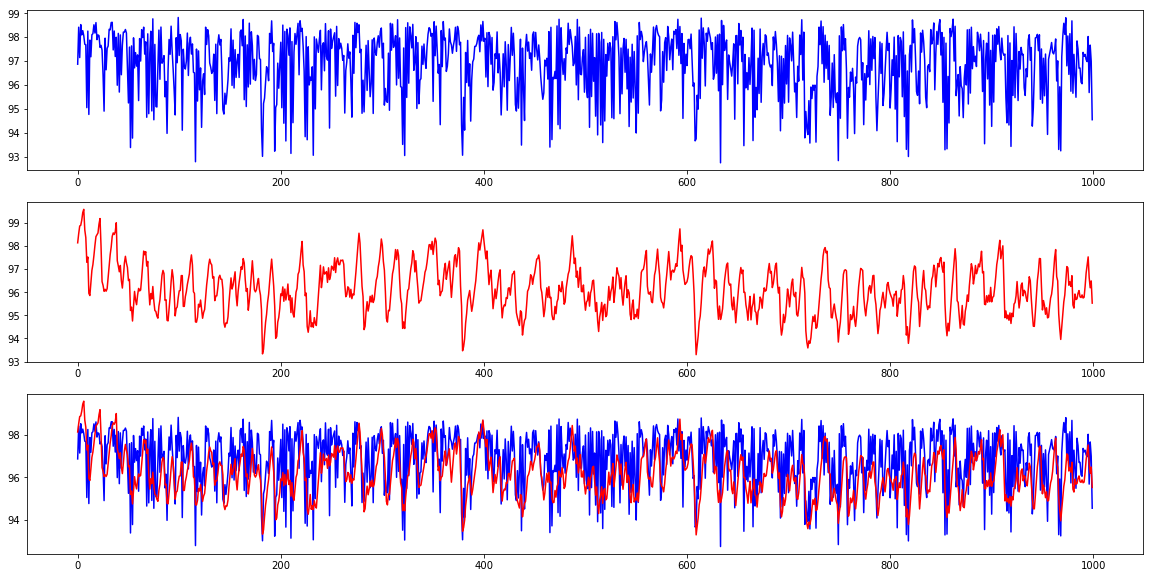

MSE on validation:  1.93255002888


In [23]:
plt.subplot(311)
plt.plot(y_hat_val, color='blue')
plt.subplot(312)
plt.plot(y_val, color='red')
plt.subplot(313)
plt.plot(y_hat_val, color='blue')
plt.plot(y_val, color='red')
plt.show()

MSE_val = mean_squared_error(y_val,y_hat_val)
print("MSE on validation: ", MSE_val)

<h3>Model Validation</h3>
<h6>Correlation tests</h6>

C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(-1, 1)

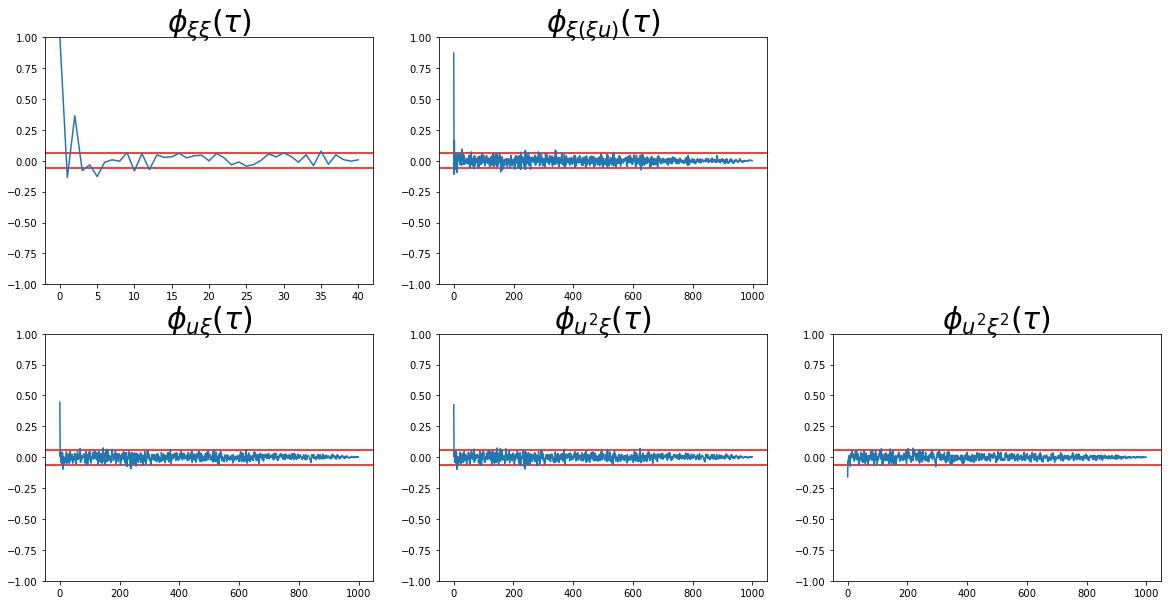

In [24]:
#import of the library
from statsmodels.tsa.stattools import acf , ccf
epsilon = np.array(y_val - y_hat_val)
u_val = np.array(u_val)

#Autocorrelation epsilon
corr_ee = acf(epsilon)

#Cross-correlation u-epsilon
corr_ue = ccf(u_val, epsilon,unbiased=False)

#Cross-correlation epsilon ( epsilon*u)
corr_e_eu = ccf(epsilon,np.multiply(epsilon[1:],u_val[1:]),unbiased=False)

#Cross-correlation delta(u^2)-epsilon
corr_du2_e = ccf(np.power(u_val,2) - np.mean(np.power(u_val,2)),epsilon, unbiased=False)

#Cross-correlation delta(u^2)-epsilon
corr_du2_e2 = ccf(np.power(u_val,2) - np.mean(np.power(u_val,2)),np.power(epsilon,2), unbiased=False)

#confidence interval   -95%
conf_interval_sup = 1.96 / np.sqrt(VAL_LENGHT)
conf_interval_inf = -1.96 / np.sqrt(VAL_LENGHT)
plt.subplot(231)
plt.title(r'$\phi_{\xi\xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_ee)
plt.ylim((-1,1))
plt.subplot(232)
plt.title(r'$\phi_{\xi(\xi u)}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_e_eu)
plt.ylim((-1,1))
plt.subplot(234)
plt.title(r'$\phi_{u \xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_ue)
plt.ylim((-1,1))
plt.subplot(235)
plt.title(r'$\phi_{u^2\xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_du2_e)
plt.ylim((-1,1))
plt.subplot(236)
plt.title(r'$\phi_{u^2\xi^2}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_du2_e2)
plt.ylim((-1,1))


<h3>Simulation</h3>

In [49]:
# start from initial phi (reg_y + reg_u), then build step by step adding new elements
poly = PolynomialFeatures(poly_degree)
reg_y = np.full(AR_deg,0)
reg_u = u_val[:X_deg]
reg = np.append(reg_u,reg_y)
reg = poly.fit_transform([reg])[0]

In [50]:
#only consider the regressor selected by the identification process
model_reg = reg[regressor_selected]  

<h5>Simulate the process</h5>

In [51]:
y_hat_sim  = []
for i in range(VAL_LENGHT - X_deg):
    y_i = np.dot(model_reg,theta) #simulated
    y_hat_sim.append(y_i)
    reg_y = np.append(reg_y, y_hat_sim[i])[1:]
    reg_u = np.append(reg_u, u_val[X_deg+i])[1:]  #append at the end, then remove the first one([:1])
    reg = np.append(reg_u,reg_y)
    reg = poly.fit_transform([reg])[0]
    model_reg = reg[regressor_selected]

Plot of the process and the simulation on the validation set

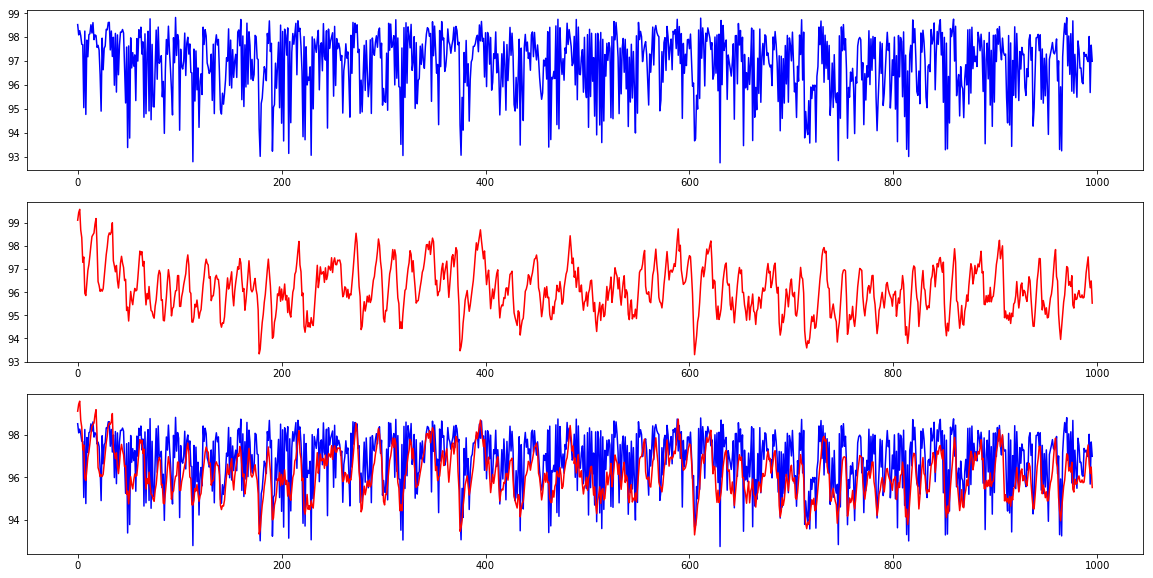

MSE on simulation:  1.86924600441


In [53]:
plt.subplot(311)
plt.plot(y_hat_sim, color='blue')
plt.subplot(312)
plt.plot(y_val[X_deg:], color='red')
plt.subplot(313)
plt.plot(y_hat_sim, color='blue')
plt.plot(y_val[X_deg:], color='red')
plt.show()

MSE_sim = mean_squared_error(y_val[X_deg:],y_hat_sim)
print("MSE on simulation: ", MSE_sim)

<p>From this code, a script has been created to test different model assumption and complexities</p>